# SLSTMCell

In [1]:
import tensorflow as tf

from tensorflow.python.distribute import distribution_strategy_context as ds_context
from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import control_flow_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.training.tracking import data_structures
from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls

class SLSTMCell(tf.keras.layers.Layer):
    """
    继承Layer并重载了5个函数，参照TF中LSTMCell源码并做了修改，源码见第 6.3.1.3 节（上一节）
    随机遮挡来自类DropoutRNNCellMixin
    """
    
    def __init__(self,
                   units,
                   activation='tanh',
                   recurrent_activation='hard_sigmoid',
                   use_bias=True,
                   kernel_initializer='glorot_uniform',
                   recurrent_initializer='orthogonal',
                   bias_initializer='zeros',
                   unit_forget_bias=True,
                   kernel_regularizer=None,
                   recurrent_regularizer=None,
                   bias_regularizer=None,
                   kernel_constraint=None,
                   recurrent_constraint=None,
                   bias_constraint=None,
                   dropout=0.,
                   recurrent_dropout=0.,
                   implementation=1,
                   **kwargs):
        #print("init start")
        self._enable_caching_device = kwargs.pop('enable_caching_device', False)
        super(SLSTMCell, self).__init__(**kwargs)
        self.num_gates = 6
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.unit_forget_bias = unit_forget_bias

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        if self.recurrent_dropout != 0 and implementation != 1:
            logging.debug(RECURRENT_DROPOUT_WARNING_MSG)
            self.implementation = 1
        else:
            self.implementation = implementation
        # tuple(_ListWrapper) was silently dropping list content in at least 2.7.10,
        # and fixed after 2.7.16. Converting the state_size to wrapper around
        # NoDependency(), so that the base_layer.__setattr__ will not convert it to
        # ListWrapper. Down the stream, self.states will be a list since it is
        # generated from nest.map_structure with list, and tuple(list) will work
        # properly.
        self.state_size = data_structures.NoDependency([self.units, self.units])
        self.output_size = self.units
        
        self.SeasonalGate = False
        
        #print("init end")

    
    
    @tf_utils.shape_type_conversion

    def build(self, input_shape):
        print("build start")

        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            # W_x: 用于和当前时刻隐层输入x做乘法的矩阵
            # 加入季节门，将self.units * 4改为self.units * 6 
            # 这里
            shape=(input_dim, self.units * self.num_gates),
            name='kernel',
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint)

        self.recurrent_kernel = self.add_weight(
            # W_h: 用于和前一时刻隐层输出h做乘法的矩阵
            # 加入季节门，将self.units * 4改为self.units * 6
            shape=(self.units, self.units * self.num_gates),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)


        if self.use_bias:
            if self.unit_forget_bias:

                def bias_initializer(_, *args, **kwargs):
                    return K.concatenate([
                          self.bias_initializer((self.units,), *args, **kwargs),
                          initializers.Ones()((self.units,), *args, **kwargs),
                          self.bias_initializer((self.units * (self.num_gates - 2),), *args, **kwargs),
                      ])
            else:
                bias_initializer = self.bias_initializer
            
            self.bias = self.add_weight(
                  shape=(self.units * self.num_gates,),
                  name='bias',
                  initializer=bias_initializer,
                  regularizer=self.bias_regularizer,
                  constraint=self.bias_constraint)

        else:
            self.bias = None
        self.built = True
        print("build end")


    def _compute_carry_and_output(self, x, h_tm1, c_tm1):
        """Computes carry and output using split kernels."""
        '''
        模式1
        采用分离法计算各个门控单元的值
        本模式尝试将选通器的判断方法调整为h_tm1和x
        本方法中x,h_tm1,c_tm1均为各个门加mask后拼成的元组，故需要多传多
        模式1中的x是 Wx+b 
        '''
        x_i, x_f, x_c, x_o, x_s1, x_s2 = x
        h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o, h_tm1_s1, h_tm1_s2 = h_tm1
        i = self.recurrent_activation(
            x_i + K.dot(h_tm1_i, self.recurrent_kernel[:, :self.units]))
        f = self.recurrent_activation(x_f + K.dot(
            h_tm1_f, self.recurrent_kernel[:, self.units:self.units * 2]))
        
        # 季节门
        
        sdB2 = 1.82
        sd = 2.41
        sdT2 = 3.58

        # 季节门1【改】
        s1 = K.tanh(x_s1 + K.dot(
            h_tm1_s1, self.recurrent_kernel[:, self.units * 4:self.units * 5]))
        # 季节门2【改】
        s2 = self.recurrent_activation(x_s2 + K.dot(
            h_tm1_s2, self.recurrent_kernel[:, self.units * 5:]))
        #【改】
        #SeasonalGate = K.max(x_s1) - K.min(x_s1) > 1.82
        if self.SeasonalGate:
            
            c = f * c_tm1 * s1 + i * self.activation(x_c + K.dot(
                h_tm1_c, self.recurrent_kernel[:, self.units * 2:self.units * 3]))
            o = self.recurrent_activation(
                x_o + K.dot(h_tm1_o, self.recurrent_kernel[:, self.units * 3:self.units * 4]))
        else:
            c = f * c_tm1 * s2 + i * self.activation(x_c + K.dot(
                h_tm1_c, self.recurrent_kernel[:, self.units * 2:self.units * 3]))
            o = self.recurrent_activation(
                x_o + K.dot(h_tm1_o, self.recurrent_kernel[:, self.units * 3:self.units * 4]))

        return c, o

    def _compute_carry_and_output_fused(self, z, c_tm1):
        """
        模式2
        Computes carry and output using fused kernels.
        使用合并向量的计算方法
        """
        
        z0, z1, z2, z3, z4, z5 = z
        i = self.recurrent_activation(z0)
        f = self.recurrent_activation(z1)
        
        #季节门
        sdB4 = 0.2828
        sdB2 = 0.5102
        sd = 0.7975
        sdT2 = 0.9501
        #if True:
        if K.max(K.softmax(c_tm1)) - K.min(K.softmax(c_tm1)) > 0.7975: #【改】
            #季节门1【改】
            s = K.tanh(z4)
            #s = K.square(s)
        else:
            #季节门2【改】
            s = self.recurrent_activation(z5)
            
        #c = f * c_tm1 + i * self.activation(z2)
        c = f * c_tm1 * s + i * self.activation(z2)
        o = self.recurrent_activation(z3)
        return c, o

    def call(self, inputs, states, training=None):
        num_gates = 6
        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1]  # previous carry state

        #dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=num_gates)
        
        #rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        #    h_tm1, training, count=num_gates)

        if self.implementation == 1:
            '''
            implementation是计算模式，1或者2
            '''
            if  K.mean(inputs) > 1 : #即inputs值大于1倍标准差
                self.SeasonalGate = True

            if 0 < self.dropout < 1.:
                inputs_i = inputs * dp_mask[0]
                inputs_f = inputs * dp_mask[1]
                inputs_c = inputs * dp_mask[2]
                inputs_o = inputs * dp_mask[3]
                inputs_s1 = inputs * dp_mask[4]
                inputs_s2 = inputs * dp_mask[5]
            else:
                inputs_i = inputs
                inputs_f = inputs
                inputs_c = inputs
                inputs_o = inputs
                inputs_s1 = inputs
                inputs_s2 = inputs
            k_i, k_f, k_c, k_o, k_s1, k_s2 = array_ops.split(
                  self.kernel, num_or_size_splits=6, axis=1)
            x_i = K.dot(inputs_i, k_i)
            x_f = K.dot(inputs_f, k_f)
            x_c = K.dot(inputs_c, k_c)
            x_o = K.dot(inputs_o, k_o)
            x_s1 = K.dot(inputs_o, k_s1)
            x_s2 = K.dot(inputs_o, k_s2)
            if self.use_bias:
                b_i, b_f, b_c, b_o, b_s1, b_s2 = array_ops.split(
                    self.bias, num_or_size_splits=6, axis=0)
                x_i = K.bias_add(x_i, b_i)
                x_f = K.bias_add(x_f, b_f)
                x_c = K.bias_add(x_c, b_c)
                x_o = K.bias_add(x_o, b_o)
                x_s1 = K.bias_add(x_o, b_s1)
                x_s2 = K.bias_add(x_o, b_s2)

            if 0 < self.recurrent_dropout < 1.:
                h_tm1_i = h_tm1 * rec_dp_mask[0]
                h_tm1_f = h_tm1 * rec_dp_mask[1]
                h_tm1_c = h_tm1 * rec_dp_mask[2]
                h_tm1_o = h_tm1 * rec_dp_mask[3]
                h_tm1_s1 = h_tm1 * rec_dp_mask[4]
                h_tm1_s2 = h_tm1 * rec_dp_mask[5]
            else:
                h_tm1_i = h_tm1
                h_tm1_f = h_tm1
                h_tm1_c = h_tm1
                h_tm1_o = h_tm1
                h_tm1_s1 = h_tm1
                h_tm1_s2 = h_tm1
            x = (x_i, x_f, x_c, x_o, x_s1, x_s2)
            h_tm1 = (h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o,h_tm1_s1,h_tm1_s2)
            c, o = self._compute_carry_and_output(x, h_tm1, c_tm1)
        else:
            # 模式2
            # 以下为使用随机遮挡的方法
            if 0. < self.dropout < 1.:
                inputs = inputs * dp_mask[0]
            
            z = K.dot(inputs, self.kernel)
            #不是z = K.dot(self.kernel, inputs)，因为x_t是行向量
            z += K.dot(h_tm1,self.recurrent_kernel)
            #不是z += K.dot(self.recurrent_kernel, h_tm1)，因为x_t是行向量
            if self.use_bias:
                z = K.bias_add(z, self.bias)
            
            z = array_ops.split(z, num_or_size_splits=num_gates, axis=1)
            c, o = self._compute_carry_and_output_fused(z, c_tm1)

        h = o * self.activation(c)
        return h, [h, c]
    
    def get_config(self):
        print("config start")

        config = {
            'units':
                self.units,
            'activation':
                activations.serialize(self.activation),
            'recurrent_activation':
                activations.serialize(self.recurrent_activation),
            'use_bias':
                self.use_bias,
            'kernel_initializer':
                initializers.serialize(self.kernel_initializer),
            'recurrent_initializer':
                initializers.serialize(self.recurrent_initializer),
            'bias_initializer':
                initializers.serialize(self.bias_initializer),
            'unit_forget_bias':
                self.unit_forget_bias,
            'kernel_regularizer':
                regularizers.serialize(self.kernel_regularizer),
            'recurrent_regularizer':
                regularizers.serialize(self.recurrent_regularizer),
            'bias_regularizer':
                regularizers.serialize(self.bias_regularizer),
            'kernel_constraint':
                constraints.serialize(self.kernel_constraint),
            'recurrent_constraint':
                constraints.serialize(self.recurrent_constraint),
            'bias_constraint':
                constraints.serialize(self.bias_constraint),
            'dropout':
                self.dropout,
            'recurrent_dropout':
                self.recurrent_dropout,
            'implementation':
                self.implementation
        }
        base_config = super(SLSTMCell, self).get_config()
        print("config end")
        return dict(list(base_config.items()) + list(config.items()))
        

    '''
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return list(_generate_zero_filled_state_for_cell(
            self, inputs, batch_size, dtype))
    
    '''
    

# 导入库

### 导入 TensorFlow 和其他库

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import numpy as np
import os
import time
import tensorflow_datasets as tfds


### 数据集

修改下面一行代码，在你自己的数据上运行此代码。

In [3]:
#path_to_file = 'economist.txt'

In [4]:
path_to_file = 'EducationContext.txt'
path_to_fileAll = 'kaoyanyingyu.txt'


### 读取数据

首先，看一看文本：

In [5]:
# 读取并为 py2 compat 解码
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
textAll = open(path_to_fileAll, 'rb').read().decode(encoding='gbk')

# 文本长度是指文本中的字符个数
print ('Length of text: {} characters'.format(len(text)))

Length of text: 2881 characters


In [6]:
# 看一看文本中的前 250 个字符
print(text[:250])

The relationship between formal education and economic growth in poor countries is widely misunderstood by economists and politicians alike progress in both area is undoubtedly necessary for the social, political and intellectual development of these


In [7]:
# 文本中的非重复字符
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

51 unique characters


## Word-coding without Embedding

### 向量化单词（不包含标点）

In [8]:
# Word-coding
# 词典集合（不重复）--dt
tz = tfds.features.text.Tokenizer() 
tzAll = tfds.features.text.Tokenizer() #全文词典

dt = set() #创建集合，可以忽略重复部分
dtAll =set() #创建所有词汇的词典

#textNew = np.array(['cripple read go'])
#textNew = u'cripple read go' #unicode string

# 取出该篇文章中所有词汇
tzs = tz.tokenize(text)
dt.update(tzs) #其实也可以创建字典-枚举类型
# 取出所有考研文章中的词汇
tzsAll = tzAll.tokenize(textAll)
dtAll.update(tzsAll)

dtSize = len(dt)
print("该篇文章的词汇量："+str(dtSize))
dtSizeAll = len(dtAll)
print("考研词汇量："+str(dtSizeAll))



该篇文章的词汇量：256
考研词汇量：14176


In [9]:
# 词集（有重复）--textWord--将该篇文章拆分为单词数组
textWord = np.array(tzs)
textWordSize = len(textWord)
print("该篇文章的单次数量："+str(textWordSize))

该篇文章的单次数量：445


In [10]:
# 构造词典--使用全考研词汇集合dtAll
# 词典 <- 枚举 <- 词典集合
dtAll = sorted(dtAll) #正序化
word2idx = {u:i for i, u in enumerate(dtAll)}
idx2word = np.array(dtAll)

#text_as_word = np.array([word2idx[c] for c in text])

In [11]:
print('{')
for word,_ in zip(word2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(word), word2idx[word]))
print('  ...\n}')

{
  '0' :   0,
  '00':   1,
  '000':   2,
  '00pm':   3,
  '075':   4,
  '1' :   5,
  '10':   6,
  '100':   7,
  '105':   8,
  '108':   9,
  '10Part':  10,
  '10th':  11,
  '11':  12,
  '110':  13,
  '1177':  14,
  '119':  15,
  '12':  16,
  '120':  17,
  '1200s':  18,
  '121':  19,
  ...
}


In [12]:
a = [2893,4777,2100,77]
print(' '.join(idx2word[a])) #使用字符串连接函数join()，其调用者为分隔符
#print(word2idx[','])

Wide compelling PhD 1909


### 预测任务
给定一个单词或者一个单词序列，下一个最可能出现的单词是什么？这就是我们训练模型要执行的任务。输入进模型的是一个单词序列，我们训练这个模型来预测输出 -- 每个时间步（time step）预测下一个单词是什么。

RNN 是根据前面看到的元素维持内部状态。

### 创建训练样本和目标

In [13]:
# 全文编码
textAsWord = np.array([word2idx[c] for c in textWord])

In [14]:
# 显示文本首 13 个单词的整数映射
print ('{} ---- words mapped to int ---- > {}'.format(repr(textWord[:13]), textAsWord[:13]))

array(['The', 'relationship', 'between', 'formal', 'education', 'and',
       'economic', 'growth', 'in', 'poor', 'countries', 'is', 'widely'],
      dtype='<U13') ---- words mapped to int ---- > [ 2658 10832  4019  6908  6045  3513  6024  7268  7765 10024  5162  8197
 13488]


In [15]:
# 设定每个输入句子长度的最大值, 这是look_back
seq_length = 1 #sequence_length 
# textWordSize是文集的长度
# examples_per_epoch = textWordSize//seq_length # 舍去余数

# 创建训练样本 / 目标
wordDataset = tf.data.Dataset.from_tensor_slices(textAsWord)

for i in wordDataset.take(3):
    print(idx2word[i.numpy()])

The
relationship
between


In [16]:
#batch的作用：在训练集中创建特定长度的序列，即批（batch）
# 在这里批容量为sequence_length+1
sequences = wordDataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(3):
    print(repr(' '.join(idx2word[item.numpy()])))

'The relationship'
'between formal'
'education and'


In [17]:
for item in sequences.take(3): #任意3条，每一条6个单词
    print(repr(' '.join(idx2word[item.numpy()])))

'The relationship'
'between formal'
'education and'


In [18]:
def split_input_target(chunk):
    input_text = chunk[:-1] #左闭右开，最后一个元素不取
    target_text = chunk[1:]
    return input_text, target_text #这是返回的元组吗？

dataset = sequences.map(split_input_target) #包含（训练集内容，训练集标签）

In [19]:
# 查看一组内容-标签，分别为上一个词和下一个词
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(' '.join(idx2word[input_example.numpy()])))
    print ('Target data:', repr(' '.join(idx2word[target_example.numpy()])))

Input data:  'The'
Target data: 'relationship'


### 创建批次训练

In [20]:
dataset = sequences.map(split_input_target)
# 批大小 ; 这里的批大小与文本长度和序列长度有关，本实验文本长度2290，序列长度设为100
BATCH_SIZE = 10 

# 设定缓冲区大小，以重新排列数据集
# （TF 数据被设计为可以处理可能是无限的序列，
# 所以它不会试图在内存中重新排列整个序列。相反，
# 它维持一个缓冲区，在缓冲区重新排列元素。） 
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((10, 1), (10, 1)), types: (tf.int64, tf.int64)>

## 创建词典模型

In [21]:
a = ["e","a"]
b = "e"
j = b in a
c = False
print(c&j)

False


In [22]:
# 词典集的长度（不重复）
print(dtSize)

# 嵌入的维度
embedding_dim = 256 #特征空间的维度

# RNN 的单元数量
#rnn_units = 1024
#run_units = 32

256


In [23]:
def build_model(vocab_size, embedding_dim, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.RNN(
            SLSTMCell(32,implementation=1,dropout=0.,use_bias=1,recurrent_initializer='glorot_uniform'),
            return_sequences=True,
            stateful=True,
            dynamic=True)),
        tf.keras.layers.RNN(
            SLSTMCell(16,implementation=1,dropout=0.,use_bias=1,recurrent_initializer='glorot_uniform'),
            return_sequences=True,
            stateful=True,
            dynamic=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [24]:
# 对照
import tensorflow as tf
def build_model_duizhao(vocab_size, embedding_dim, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                             return_sequences=True,
                             stateful=True,
                             recurrent_initializer='glorot_uniform')),
        tf.keras.layers.LSTM(16,
                             return_sequences=True,
                             stateful=True,
                             recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [47]:
model = build_model(
  vocab_size = dtSizeAll,
  embedding_dim=embedding_dim,
  batch_size=BATCH_SIZE)

config start
config end
config start
config end


In [26]:
# 对照模型：LSTM
model = build_model_duizhao(
  vocab_size = dtSizeAll,
  embedding_dim=embedding_dim,
  batch_size=BATCH_SIZE)

## 试试词典模型

In [48]:
# 检查输出形状
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
    
print(input_example_batch)

build start
build end
build start
build end
build start
build end
(10, 1, 14176) # (batch_size, sequence_length, vocab_size)
tf.Tensor(
[[ 3100]
 [ 7459]
 [10681]
 [10558]
 [11741]
 [12519]
 [ 3202]
 [ 9801]
 [ 9539]
 [ 6045]], shape=(10, 1), dtype=int64)


In [49]:
# example_batch_predictions是未经训练的模型的预测值
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
print("Input: \n", repr(" ".join(idx2word[(input_example_batch[0]).numpy()])))
print()
print("Next Word Predictions: \n", repr(" ".join(idx2word[sampled_indices])))

Input: 
 'a'

Next Word Predictions: 
 'host'


In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (10, None, 256)           3629056   
_________________________________________________________________
bidirectional_5 (Bidirection (10, None, 64)            110976    
_________________________________________________________________
rnn_7 (RNN)                  (10, None, 16)            7776      
_________________________________________________________________
dense_5 (Dense)              (10, None, 14176)         240992    
Total params: 3,988,800
Trainable params: 3,988,800
Non-trainable params: 0
_________________________________________________________________


## 训练词典模型

In [51]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    #return tf.keras.losses.categorical_crossentropy(labels, logits, from_logits=True)
    #return tf.keras.losses.cosine_proximity(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (10, 1, 14176)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       9.559317


In [52]:
model.compile(optimizer='adam', loss=loss)

In [53]:
# 检查点保存至的目录
checkpoint_dir = './training_checkpoints'

# 检查点的文件名
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [54]:
EPOCHS=30

In [55]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
#history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/30
22/22 [==============================] - 4s 161ms/step - loss: 9.5547
Epoch 2/30
22/22 [==============================] - 4s 167ms/step - loss: 9.5208
Epoch 3/30
22/22 [==============================] - 4s 160ms/step - loss: 9.3229
Epoch 4/30
22/22 [==============================] - 4s 163ms/step - loss: 8.1240
Epoch 5/30
22/22 [==============================] - 4s 169ms/step - loss: 7.2527
Epoch 6/30
22/22 [==============================] - 4s 186ms/step - loss: 6.6254
Epoch 7/30
22/22 [==============================] - 4s 168ms/step - loss: 6.1504
Epoch 8/30
22/22 [==============================] - 4s 173ms/step - loss: 5.7877
Epoch 9/30
22/22 [==============================] - 4s 192ms/step - loss: 5.5434
Epoch 10/30
22/22 [==============================] - 4s 181ms/step - loss: 5.3517
Epoch 11/30
22/22 [==============================] - 4s 178ms/step - loss: 5.2415
Epoch 12/30
22/22 [==============================] - 4s 165ms/step - loss: 5.1307
Epoch 13/30
22/22 [======

In [56]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
def plot_train_history(history, title):
    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    #plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

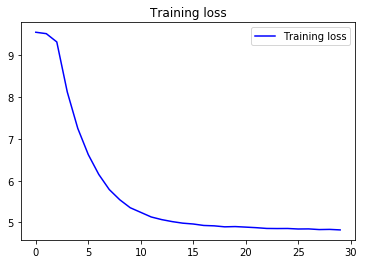

In [57]:
plot_train_history(history,"Training loss")

In [69]:
# 备份多输入输出模型 pastoral pickle intricacy award
model_copy = model
#model = model_copy


## 生成文本

In [76]:
# 重新生成一个单输出模型
# 调整为单输入输出，即batch_size=1
model = build_model(dtSizeAll, embedding_dim, batch_size=1)


config start
config end
config start
config end


In [60]:
# 注意这是对照
# 调整为单输入输出，即batch_size=1
model = build_model_duizhao(dtSizeAll, embedding_dim, batch_size=1)


In [94]:
# 加载训练权重，在TF2.5.0中这个函数的写法是否有变化，查看相应API
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir)) # 返回最新的训练权重

model.build(tf.TensorShape([1, None]))


In [95]:
# 多变量多步接力预测
def generate_textWord(model, start_string,num_generate):
    # 评估步骤（用学习过的模型生成文本）

    # 要生成的单词个数
    #num_generate = num_generate
    
    # 将start_string拆分
    tz = tfds.features.text.Tokenizer()
    #dt = set() #创建集合，可以忽略重复部分
    tzs = tz.tokenize(start_string)
    #start_string = tzs
    #start_string = tzs.numpy()

    # 将起始字符串转换为数字（向量化）
    input_eval = [word2idx[s] for s in tzs]
    input_eval = tf.expand_dims(input_eval, 0) #新加第0维度，为了能代入模型，模型中第0维是批量

    # 空列表用于存储结果
    text_generated = []

    # 低温度会生成更可预测的文本 #?
    # 较高温度会生成更令人惊讶的文本
    # 可以通过试验以找到最好的设定
    temperature = 0.8

    # 这里批大小为 1
    #model.reset_states() # 对于自定义的RNN，在TF2.5.0中不能包含此句
    for i in range(num_generate):
        predictions = model(input_eval)
        # 删除批次的维度
        predictions = tf.squeeze(predictions, 0) #删去第0维度

        # 用分类分布预测模型返回的字符
        predictions = predictions / temperature #为什么？
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        # tf.random.categorical 把输入当做权重得分，维度为batch_size x num_classes，
        # 其实可以理解为softmax过程
        # 在这里num_classes就是词表长度
        # num_samples即是抽样次数，超参数
        # 返回值为抽样结果（对每个batch进行多次抽样）维度为：batch_size x num_samples
        # 相当于在softmax的基础上增加了随机扰动
        
        # 把预测字符和前面的隐藏状态一起传递给模型作为下一个输入
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2word[predicted_id]) #predicted_id是位置坐标
        
        res = ' '.join(text_generated) #添加一个新词

    return(start_string+" "+res)

In [96]:
a = tf.random.categorical([[-1.20397282,-0.9162907,-1.60943794,-2.30258512],[-1.20397282,-0.9162907,-1.60943794,-2.30258512]],num_samples=6)[-1,0].numpy()
print(a)


1


In [97]:
question = "The author holds in Paragraph 1 that the importance of education in poor countries"
answer1 = "has been overestimated"
strstr = [question, answer1]
num_strstr = len(strstr[1].split())
num_strstr

3

In [98]:
def acchyh(num_samples):
    num_res = 0
    for i in range(num_samples):
        res = generate_textWord(model,"the relationship between education",10)
        res = res.split()
        keywords = ["economic","economy","economist"]
        jugement = False
        for j in range(len(keywords)):
            jugement = jugement | (keywords[j] in res)
        if jugement:
            num_res = num_res +1
    return(num_res/num_samples)


In [99]:
acchyh(100)

0.16

In [1]:
# 备份单输入输出模型
#slstm_sigmoid_1by2 = model
#lstm_sigmoid = model